In this notebook we explore items in the Global Biodiversity Information Facility (GBIF)
https://planetarycomputer.microsoft.com/dataset/gbif

In particular we:
- filter columns and rows of a single asset
- transform the resulting pandas dataframe into a geopandas dataframe
- identify sightings within a specific region using a shapefile
- plot results

# OPENING GBIF CATALOG AND SELECTING ITEMS

In [1]:
import pystac_client # access STAC catalogs

# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)


search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}
list(items)

['gbif-2021-09-01',
 'gbif-2021-08-01',
 'gbif-2021-07-01',
 'gbif-2021-06-01',
 'gbif-2021-04-13']

In [2]:
item = list(items.values())[0]
print(item)

<Item id=gbif-2021-09-01>


In [3]:
#As usual, you should sign the item before trying to load the data.
import planetary_computer

signed_asset = planetary_computer.sign(item).assets["data"]

In [4]:
# read data frame using parquet, specify columns

import dask.dataframe as dd

df = dd.read_parquet(
    signed_asset.href,
    columns=["species",
            "countrycode",
            "stateprovince",
            "decimallatitude",
            "decimallongitude",
            "coordinateuncertaintyinmeters",
            "day",
            "month",
            "year",
            "institutioncode"],
    storage_options=signed_asset.extra_fields["table:storage_options"],  #???
)
df


,species,countrycode,stateprovince,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,day,month,year,institutioncode
npartitions=1034,,,,,,,,,,
,object,object,object,float64,float64,float64,int32,int32,int32,object
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...



As indicated by npartitions, this Parquet dataset is made up of many individual parquet files. We can read in a specific partition with .get_partition

In [5]:
chunk = df.get_partition(0).compute()
print(type(chunk))
chunk

<class 'pandas.core.frame.DataFrame'>


,species,countrycode,stateprovince,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,day,month,year,institutioncode
0,Globigerina bulloides,None,None,47.1800,-19.5850,NaN,24.0,10.0,1996.0,Pangaea
1,Neogloboquadrina pachyderma,None,None,47.1800,-19.5850,NaN,24.0,10.0,1996.0,Pangaea
2,Globigerinita minuta,None,None,47.1800,-19.5850,NaN,24.0,10.0,1996.0,Pangaea
3,Globigerinita glutinata,None,None,47.1800,-19.5850,NaN,24.0,10.0,1996.0,Pangaea
4,Globigerina falconensis,None,None,47.1800,-19.5850,NaN,24.0,10.0,1996.0,Pangaea
...,...,...,...,...,...,...,...,...,...,...
1667009,Processa bermudensis,US,None,25.7656,-82.1558,NaN,29.0,7.0,1981.0,USNM
1667010,Hybomys univittatus,CF,Sangha-Mbaere,2.7800,16.4200,NaN,17.0,11.0,1993.0,USNM
1667011,Plethodon montanus,US,Virginia,36.6578,-81.5569,NaN,14.0,8.0,1977.0,USNM
1667012,None,MX,Baja California,29.3167,-117.0170,NaN,30.0,10.0,1969.0,USNM


In [6]:
# exploring chunk

import pandas as pd

#pd.unique(chunk['countrycode'])

#province =  pd.unique(chunk['stateprovince'])
#for x in province:
#    print(x)

In [7]:
# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

# select stateprovince == 'California'
chunk = chunk.loc[chunk['stateprovince'] == 'California']
chunk

,species,countrycode,stateprovince,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,day,month,year,institutioncode
1508701,None,US,California,32.650000,-117.133000,NaN,31.0,3.0,1896.0,USNM
1508748,Bombus rufocinctus,US,California,38.020000,-119.930000,NaN,7.0,8.0,1974.0,USNM
1508758,Bombus bifarius,US,California,38.020000,-119.930000,NaN,12.0,8.0,1974.0,USNM
1508798,Thamnophis atratus,US,California,37.758441,-122.444778,6488.88,NaN,NaN,NaN,USNM
1508807,Acanthinucella spirata,US,California,34.018100,-120.372000,NaN,6.0,2.0,1978.0,USNM
...,...,...,...,...,...,...,...,...,...,...
1666896,Bombus bifarius,US,California,38.020000,-119.930000,NaN,13.0,8.0,1974.0,USNM
1666929,None,US,California,40.866500,-124.083000,5461.00,NaN,NaN,NaN,USNM
1666953,Pyrgulopsis giulianii,US,California,35.733000,-118.333000,NaN,NaN,NaN,1988.0,USNM
1666961,Amphipholis pugetana,US,California,34.423600,-120.333000,NaN,8.0,1.0,1889.0,USNM


In [8]:
ca_sightings = chunk.filter(items=['species', 'decimallatitude', 'decimallongitude'])
ca_sightings

,species,decimallatitude,decimallongitude
1508701,None,32.650000,-117.133000
1508748,Bombus rufocinctus,38.020000,-119.930000
1508758,Bombus bifarius,38.020000,-119.930000
1508798,Thamnophis atratus,37.758441,-122.444778
1508807,Acanthinucella spirata,34.018100,-120.372000
...,...,...,...
1666896,Bombus bifarius,38.020000,-119.930000
1666929,None,40.866500,-124.083000
1666953,Pyrgulopsis giulianii,35.733000,-118.333000
1666961,Amphipholis pugetana,34.423600,-120.333000


# CONVERT INTO geopandas dataframe

In [9]:
# https://gis.stackexchange.com/questions/174159/converting-pandas-dataframe-to-geodataframe
# https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
import geopandas

gdf = geopandas.GeoDataFrame(
    ca_sightings, 
    geometry = geopandas.points_from_xy(x=ca_sightings.decimallongitude, y=ca_sightings.decimallatitude)
)
gdf
# CAUTION: some species = None

,species,decimallatitude,decimallongitude,geometry
1508701,None,32.650000,-117.133000,POINT (-117.13300 32.65000)
1508748,Bombus rufocinctus,38.020000,-119.930000,POINT (-119.93000 38.02000)
1508758,Bombus bifarius,38.020000,-119.930000,POINT (-119.93000 38.02000)
1508798,Thamnophis atratus,37.758441,-122.444778,POINT (-122.44478 37.75844)
1508807,Acanthinucella spirata,34.018100,-120.372000,POINT (-120.37200 34.01810)
...,...,...,...,...
1666896,Bombus bifarius,38.020000,-119.930000,POINT (-119.93000 38.02000)
1666929,None,40.866500,-124.083000,POINT (-124.08300 40.86650)
1666953,Pyrgulopsis giulianii,35.733000,-118.333000,POINT (-118.33300 35.73300)
1666961,Amphipholis pugetana,34.423600,-120.333000,POINT (-120.33300 34.42360)


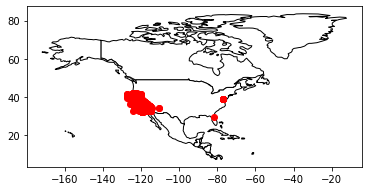

In [10]:
# Plot everything on North America map

import matplotlib.pyplot as plt

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')
plt.show()

# FINDING SEDGWICK SIGHTINGS

To find whcih sightings on the gdf are within Sedwick we will need:
1. Sedgwick shapefile
2. gdf and shapefile must have same crs

This is based on the following workflow on R:
https://data-blog.gbif.org/post/shapefiles/

In [11]:
# ---- OPENING SHAPEFILE ----

import geopandas as gpd # to open shapefile

sedg_shp_path = "/home/jovyan/Sedgwick_Reserve/sedgwick_geometry/sedgwick_geometry.shp"
sedg_shp = gpd.read_file(sedg_shp_path)
#sedg_shp.plot(edgecolor='purple', color='yellow')
sedg_shp.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Match CRS

To match the CRS we need to
1. make sure gdf has a crs to begin with
    `gdf.crs`
2. if it does not have one, then assign the correct crs with
    `gdf.set_crs()`. If it already has a crs then change it using `gdf.set_crs(#, allow_override=True)`
3. match the crs of gdf with shapefile using `gdf = gdf.to_crs()`


More about `.set_crs` and `.to_crs`
https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html#geopandas.GeoDataFrame.to_crs



In [12]:
# ----- ASSIGN CRS TO geodataframe -----
print(gdf.crs)

gdf = gdf.set_crs(4326)

gdf.crs

None


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
# ----- MATCH CRS of geodataframe WITH shapefile -----

gdf = gdf.to_crs(sedg_shp.crs)
gdf.crs  # ? what happens with observations outside these coordiantes
# probably best to query data to be in lat long within the bounding box of AOI

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
# ---- FIND SIGHTINGS WITHIN shapefile -----
sedgwick = gpd.clip(gdf,sedg_shp)
sedgwick

,species,decimallatitude,decimallongitude,geometry


# FINDING SANTA BARBARA SIGHTINGS

Same procedure of cliping geodataframe to Santa Barbara shapefile. 
Here there are some sights so we will plot these. 

SB shapefile from:
https://databasin.org/datasets/1cdc07adea7d4dee9cc1f07ab44cfef3/

epsg:3310


<AxesSubplot:>

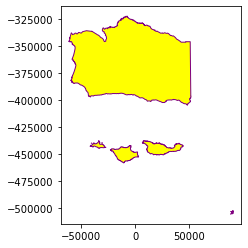

In [15]:
# ---- OPEN SB shapefile ----

sb_shape_path = "/home/jovyan/Sedgwick_Reserve/SB_geometry/SB_only.shp"
sb_shape = gpd.read_file(sb_shape_path)
print(sb_shape.crs)
sb_shape.plot(edgecolor='purple', color='yellow')



In [16]:
# ---- FIND SIGHTINGS WITHIN shapefile -----

santa_barbara = gpd.clip(gdf,sb_shape)
santa_barbara

,species,decimallatitude,decimallongitude,geometry
1508807,Acanthinucella spirata,34.018100,-120.372000,POINT (-34358.937 -444091.784)
1509951,Clathria pennata,34.048600,-120.336000,POINT (-31021.868 -440720.925)
1510256,Sceloporus graciosus,34.694839,-119.641679,POINT (32812.171 -369003.671)
1511074,Tectura paleacea,34.407500,-119.878000,POINT (11213.134 -400948.801)
1511373,Pollicipes polymerus,34.020400,-119.687000,POINT (28909.232 -443856.166)
...,...,...,...,...
1662219,Lacuna unifasciata,34.048600,-120.336000,POINT (-31021.868 -440720.925)
1663751,Crotalus viridis,34.427645,-119.707677,POINT (26860.215 -398679.020)
1664022,Pseudacris regilla,34.427645,-119.707677,POINT (26860.215 -398679.020)
1665993,Leptopecten latiauratus,33.970000,-120.100000,POINT (-9241.707 -449489.211)


## Plot shapefile + geodataframe

Reference: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73

We also plot Sedgwick reserve to see how there are no sights within the reserve.

<AxesSubplot:>

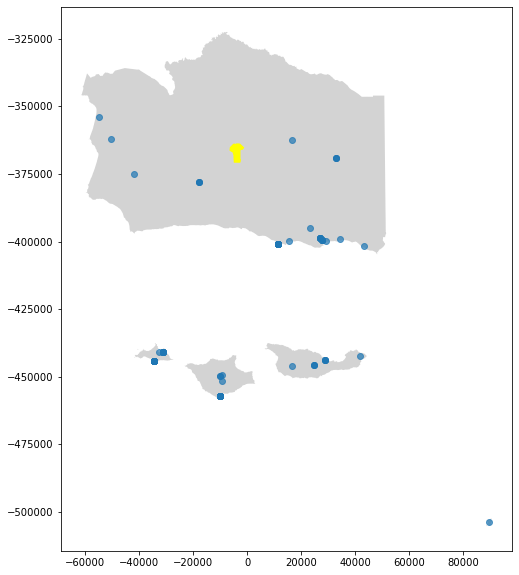

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,10))
sb_shape.plot(ax=ax, color='lightgrey')
santa_barbara.plot(ax=ax, alpha=0.7)
sedg_shp.plot(ax=ax, color='yellow')
#ax.set_title('Kings County Real Estate')